In [1]:
%pip install geojson
%pip install geopandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import geojson
import geopandas as gpd

In [22]:
# Read the GeoJSON training file
gdf_train = gpd.read_file('data/train.geojson')
gdf_test = gpd.read_file('data/test.geojson')
# Display the first few rows of the GeoDataFrame
print(gdf_train.shape)
print(gdf_test.shape)


(20, 3)
(6, 3)


In [49]:
gdf_train.tail()

,id,label,geometry
15,15,0,"POLYGON ((21.79166 47.12736, 21.81149 47.12736..."
16,16,0,"POLYGON ((-86.26424 12.16055, -86.25044 12.160..."
17,17,0,"POLYGON ((106.94959 -6.33485, 106.96317 -6.334..."
18,18,0,"POLYGON ((-74.14197 40.53721, -74.12421 40.537..."
19,19,0,"POLYGON ((23.71918 46.79306, 23.73889 46.79306..."


In [27]:
gdf_train.iloc[0]

id                                                          0
label                                                       1
geometry    POLYGON ((-99.02345225548716 19.44625108795561...
Name: 0, dtype: object

In [28]:
%pip install pystac
%pip install pystac_client
%pip install planetary_computer

Note: you may need to restart the kernel to use updated packages.
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [31]:
%pip install rasterio

Note: you may need to restart the kernel to use updated packages.


In [29]:
from pystac.extensions.eo import EOExtension as eo
import pystac_client
import planetary_computer
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp

import numpy as np
from PIL import Image

In [30]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [74]:
area_of_interest = gdf_train.iloc[5]['geometry']
time_of_interest = "2022-01-01/2022-12-30"

Returned 28 Items
Choosing S2B_MSIL2A_20220620T093039_R136_T34TET_20220621T140717 from 2022-06-20 with 0.000435% cloud cover


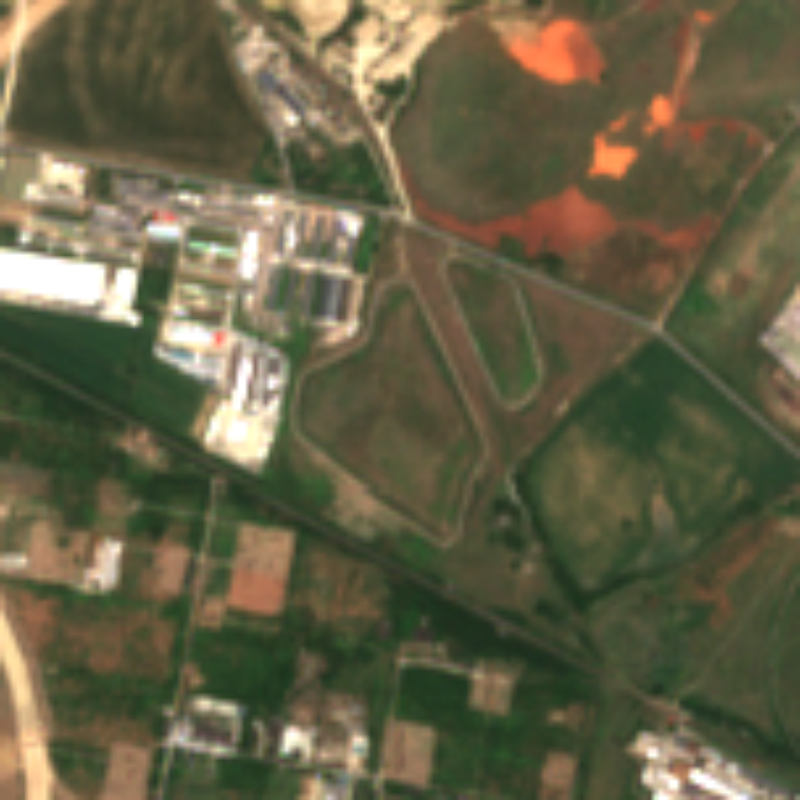

In [75]:
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

# Check how many items were returned
items = search.item_collection()
print(f"Returned {len(items)} Items")

least_cloudy_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {least_cloudy_item.id} from {least_cloudy_item.datetime.date()}"
    f" with {eo.ext(least_cloudy_item).cloud_cover}% cloud cover"
)


asset_href = least_cloudy_item.assets["visual"].href

with rasterio.open(asset_href) as ds:
    aoi_bounds = features.bounds(area_of_interest)
    warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
    aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
    band_data = ds.read(window=aoi_window)

img = Image.fromarray(np.transpose(band_data, axes=[1, 2, 0]))
w = img.size[0]
h = img.size[1]
aspect = w / h
target_w = 800
target_h = (int)(target_w / aspect)
img.resize((target_w, target_h), Image.Resampling.BILINEAR)

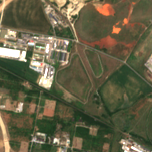

In [78]:
img

In [99]:
img.size

(152, 152)

In [100]:
band_data.shape

(3, 152, 152)

In [96]:
type(band_data)

numpy.ndarray

In [97]:
gdf_train.iloc[0]['label']

1

In [107]:
def getimgdata(area_of_interest):
    search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
    )

    # Check how many items were returned
    items = search.item_collection()
    print(f"Returned {len(items)} Items")

    least_cloudy_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

    print(
        f"Choosing {least_cloudy_item.id} from {least_cloudy_item.datetime.date()}"
        f" with {eo.ext(least_cloudy_item).cloud_cover}% cloud cover"
    )


    asset_href = least_cloudy_item.assets["visual"].href

    with rasterio.open(asset_href) as ds:
        aoi_bounds = features.bounds(area_of_interest)
        warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
        band_data = ds.read(window=aoi_window)
    
    return band_data


In [121]:
img_data = []
for i in range(len(gdf_train)):
    img_data.append(( getimgdata(gdf_train.iloc[i]['geometry']), gdf_train.iloc[i]['label']))
    

Returned 19 Items
Choosing S2A_MSIL2A_20220401T165851_R069_T14QMG_20220402T074055 from 2022-04-01 with 1e-05% cloud cover
Returned 49 Items
Choosing S2B_MSIL2A_20220630T093039_R136_T34TGS_20220630T232604 from 2022-06-30 with 0.001051% cloud cover
Returned 19 Items
Choosing S2B_MSIL2A_20220428T130239_R095_T23KPQ_20220429T070446 from 2022-04-28 with 0.015456% cloud cover
Returned 1 Items
Choosing S2B_MSIL2A_20220112T022039_R003_T51PTS_20220112T211208 from 2022-01-12 with 5.427695% cloud cover
Returned 12 Items
Choosing S2B_MSIL2A_20220227T073849_R092_T37MBU_20220302T175301 from 2022-02-27 with 0.042714% cloud cover
Returned 28 Items
Choosing S2B_MSIL2A_20220620T093039_R136_T34TET_20220621T140717 from 2022-06-20 with 0.000435% cloud cover
Returned 9 Items
Choosing S2B_MSIL2A_20220207T160429_R097_T16PEU_20220221T092128 from 2022-02-07 with 0.022858% cloud cover
Returned 4 Items
Choosing S2A_MSIL2A_20220718T025541_R032_T48MYU_20220718T142042 from 2022-07-18 with 3.841336% cloud cover
Return

In [123]:
img_data[0][1]

1